### Try-it 8.1: The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import researchpy as rp 
from scipy.linalg import svd
from sklearn.datasets import make_regression
from sklearn.datasets import fetch_openml
import sklearn.cluster as cluster
np.random.seed(1234)
import warnings
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
import plotly.express as px
import plotly.graph_objects as go
import scipy.optimize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from scipy import stats
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

warnings.filterwarnings("ignore")


In [76]:
cali = pd.read_csv('data/housing.csv')
cali.shape

(20640, 10)

In [77]:
cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [78]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [79]:
# create df 

# Since total_bedrooms, households and total_rooms all have a VIF > 10, I derive household level variables below. 
# Better by zipcode except that we don't have a zipcode variable. Average number of bedrooms seems inflated
df = cali

df['avg_rooms'] = df['total_rooms']/df['households']  
df['avg_bedrooms'] = df['total_bedrooms']/df['households']  

# log transform y
df['median_house_value_sqrt'] = np.sqrt(df['median_house_value'])
df 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms,avg_bedrooms,median_house_value_sqrt
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,672.755528
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,598.748695
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,593.380148
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,584.208867
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,584.978632
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5.045455,1.133333,279.463772
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,6.114035,1.315789,277.668868
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5.205543,1.120092,303.809151
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5.329513,1.171920,291.032644


In [80]:
# Drop extreme outlying records
df = df[df['avg_rooms'] <= 80]

In [179]:
# derive zipcode

import pandas as pd
from geopy.geocoders import Nominatim

# Initialize geocoder
geolocator = Nominatim(user_agent="zipcode_lookup")

# Define a function to get zipcode from latitude and longitude
def get_zipcode(latitude, longitude):
    location = geolocator.reverse((latitude, longitude), exactly_one=True)
    if location:
        address = location.raw['address']
        zipcode = address.get('postcode', None)
        return zipcode
    return None

# Apply reverse geocoding function to each row
df['zipcode'] = df.apply(lambda row: get_zipcode(row['latitude'], row['longitude']), axis=1)

# Save the updated dataset
df.to_csv('updated_cali.csv', index=False)  # Replace 'updated_dataset.csv' with desired filename


KeyboardInterrupt: 

In [81]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,avg_rooms,avg_bedrooms,median_house_value_sqrt
count,20638.000000,20638.000000,20638.000000,20638.000000,20431.000000,20638.000000,20638.000000,20638.000000,20638.000000,20638.000000,20431.000000,20638.000000
mean,-119.569654,35.631549,28.639015,2635.846545,537.884391,1425.611687,499.586830,3.870731,206843.761992,5.416228,1.094248,437.958921
std,2.003622,2.135820,12.586076,2181.703474,421.401851,1132.434021,382.318274,1.899856,115382.750510,2.106307,0.379484,122.623303
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,122.470405
25%,-121.800000,33.930000,18.000000,1447.250000,296.000000,787.000000,280.000000,2.563750,119600.000000,4.440652,1.006017,345.832329
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.228973,1.048872,423.910368
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743550,264700.000000,6.052120,1.099608,514.490039
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,62.422222,15.312500,707.107488


In [82]:
#encode categorical variables
rp.summary_cat(df['ocean_proximity'])

,Variable,Outcome,Count,Percent
0,ocean_proximity,<1H OCEAN,9136,44.27
1,,INLAND,6549,31.73
2,,NEAR OCEAN,2658,12.88
3,,NEAR BAY,2290,11.10
4,,ISLAND,5,0.02


In [83]:
# Using OneHotEncoder encoder

# cat_cols  -  list of categorical column names
cat_cols = ['ocean_proximity']

# Extract categorical variables into a separate DataFrame
cat_df = df[cat_cols]

# Initialize OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the categorical variables
cat_encoded = encoder.fit_transform(cat_df)

# Convert the encoded matrix to a DataFrame
cat_encoded_df = pd.DataFrame(cat_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the one-hot encoded DataFrame with the original DataFrame
df_encoded = pd.concat([df, cat_encoded_df], axis=1)

# Drop the original categorical variables if needed
#df_encoded.drop(cat_cols, axis=1, inplace=True)


In [84]:
df_encoded

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,avg_rooms,avg_bedrooms,median_house_value_sqrt,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,672.755528,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,598.748695,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,593.380148,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,584.208867,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,584.978632,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5.205543,1.120092,303.809151,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5.329513,1.171920,291.032644,NaN,NaN,NaN,NaN,NaN
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND,5.254717,1.162264,298.998328,NaN,NaN,NaN,NaN,NaN
1914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0


In [85]:
# Using label encoder
df_encoded.rename(columns={'ocean_proximity': 'ocean_proximity_orig'}, inplace=True)

encoder = LabelEncoder()

# Fit and transform the "Category" column
df_encoded['ocean_proximity'] = encoder.fit_transform(df_encoded['ocean_proximity_orig'])

df = df_encoded
# Print the encoded DataFrame
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_orig,avg_rooms,avg_bedrooms,median_house_value_sqrt,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,672.755528,0.0,0.0,0.0,1.0,0.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,598.748695,0.0,0.0,0.0,1.0,0.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,593.380148,0.0,0.0,0.0,1.0,0.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,584.208867,0.0,0.0,0.0,1.0,0.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,584.978632,0.0,0.0,0.0,1.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,5.205543,1.120092,303.809151,0.0,1.0,0.0,0.0,0.0,1
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,5.329513,1.171920,291.032644,NaN,NaN,NaN,NaN,NaN,1
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND,5.254717,1.162264,298.998328,NaN,NaN,NaN,NaN,NaN,1
1914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,5


In [86]:
# Identify and drop any duplicated records
duplicates = df[df.duplicated()]
df.drop_duplicates(inplace=True)
df.shape

(20639, 19)

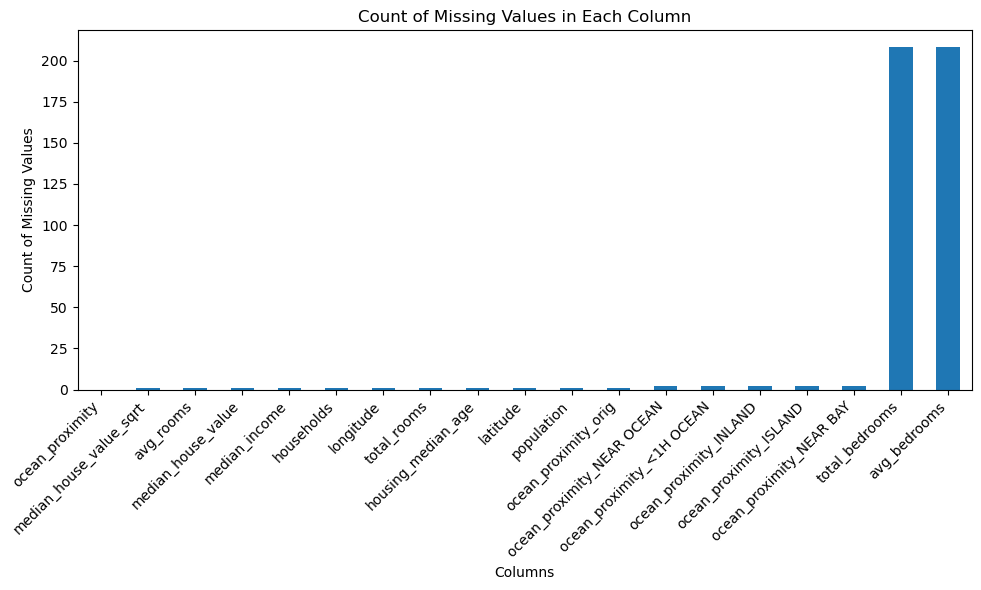

In [87]:
# Check misingness rates 
missing_values_count = df.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

In [88]:
# Percent missingness
# Replace 'X' with the column name you want to check for missing values
column_name = 'total_bedrooms'

# Compute the percentage of missing values in the specified column
missing_percentage = (df[column_name].isnull().sum() / len(df)) * 100

print(f"The percentage of missing values in column '{column_name}' is: {missing_percentage:.2f}%")

The percentage of missing values in column 'total_bedrooms' is: 1.01%


In [89]:
cali.shape

(20640, 13)

In [90]:
columns_with_nan = df.columns[df.isnull().sum() > 0]

# Print the columns containing NaN values
print(columns_with_nan)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_orig', 'avg_rooms',
       'avg_bedrooms', 'median_house_value_sqrt', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')


In [91]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

longitude                       1
latitude                        1
housing_median_age              1
total_rooms                     1
total_bedrooms                208
population                      1
households                      1
median_income                   1
median_house_value              1
ocean_proximity_orig            1
avg_rooms                       1
avg_bedrooms                  208
median_house_value_sqrt         1
ocean_proximity_<1H OCEAN       2
ocean_proximity_INLAND          2
ocean_proximity_ISLAND          2
ocean_proximity_NEAR BAY        2
ocean_proximity_NEAR OCEAN      2
ocean_proximity                 0
dtype: int64


In [92]:
# Drop rows with missing values
df_c = df.dropna()
df_c.shape

(20429, 19)

In [93]:
df = df_c
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_orig,avg_rooms,avg_bedrooms,median_house_value_sqrt,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,672.755528,0.0,0.0,0.0,1.0,0.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,598.748695,0.0,0.0,0.0,1.0,0.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,593.380148,0.0,0.0,0.0,1.0,0.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,584.208867,0.0,0.0,0.0,1.0,0.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,584.978632,0.0,0.0,0.0,1.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20633,-121.53,39.19,27.0,2080.0,412.0,1082.0,382.0,2.5495,98300.0,INLAND,5.445026,1.078534,313.528308,0.0,1.0,0.0,0.0,0.0,1
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND,6.779070,1.148256,341.760150,0.0,1.0,0.0,0.0,0.0,1
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5.045455,1.133333,279.463772,0.0,1.0,0.0,0.0,0.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,6.114035,1.315789,277.668868,0.0,1.0,0.0,0.0,0.0,1


In [94]:
df_filled = df.fillna('')
df = df_filled

In [95]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_orig          0
avg_rooms                     0
avg_bedrooms                  0
median_house_value_sqrt       0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
ocean_proximity               0
dtype: int64


In [96]:
pd.crosstab(df['ocean_proximity_orig'], df['ocean_proximity'], dropna=False, margins=True) 

ocean_proximity,0,1,2,3,4,All
ocean_proximity_orig,,,,,,
<1H OCEAN,9034,0,0,0,0,9034
INLAND,0,6492,0,0,0,6492
ISLAND,0,0,5,0,0,5
NEAR BAY,0,0,0,2270,0,2270
NEAR OCEAN,0,0,0,0,2628,2628
All,9034,6492,5,2270,2628,20429


In [97]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_orig', 'avg_rooms',
       'avg_bedrooms', 'median_house_value_sqrt', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'ocean_proximity'],
      dtype='object')

In [366]:
# df.drop(columns=['ocean_proximity_orig', 'ocean_proximity'], inplace=True)

In [ ]:
# Limitations: Data is aggregate and not at household level
# May need to derive average rooms per household, average bedrooms per household, average people per household,etc.?
# Challenge is creating new variables that a linear combinations of others causing more multi-collinearity

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20429 entries, 0 to 20637
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   longitude                   20429 non-null  float64
 1   latitude                    20429 non-null  float64
 2   housing_median_age          20429 non-null  float64
 3   total_rooms                 20429 non-null  float64
 4   total_bedrooms              20429 non-null  float64
 5   population                  20429 non-null  float64
 6   households                  20429 non-null  float64
 7   median_income               20429 non-null  float64
 8   median_house_value          20429 non-null  float64
 9   ocean_proximity_orig        20429 non-null  object 
 10  avg_rooms                   20429 non-null  float64
 11  avg_bedrooms                20429 non-null  float64
 12  median_house_value_sqrt     20429 non-null  float64
 13  ocean_proximity_<1H OCEAN   20429 no

In [ ]:
#Visualize the data before splitting

In [99]:
#rp.summary_cont(df['median_house_value'])

column_name = 'median_house_value_sqrt'

# Compute the summary statistics manually
summary_stats = {
    'mean': df[column_name].mean(),
    'std_dev': df[column_name].std(),
    'median': df[column_name].median(),
    'p5': df[column_name].quantile(0.05),
    'q1': np.percentile(df[column_name], 25),
    'q3': np.percentile(df[column_name], 75),
    'p90': df[column_name].quantile(0.9),
    'p95': df[column_name].quantile(0.95),    
    'min': df[column_name].min(),
    'max': df[column_name].max()
}

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats, index=[column_name])

# Print the summary statistics
print(summary_df)

                               mean     std_dev      median          p5  \
median_house_value_sqrt  437.974306  122.650763  424.028301  257.371309   

                                q1          q3         p90         p95  \
median_house_value_sqrt  345.68772  514.490039  613.693734  700.257095   

                                min         max  
median_house_value_sqrt  122.470405  707.107488  


Shapiro-Wilk Test - Test Statistic: 0.971041738986969, p-value: 0.0


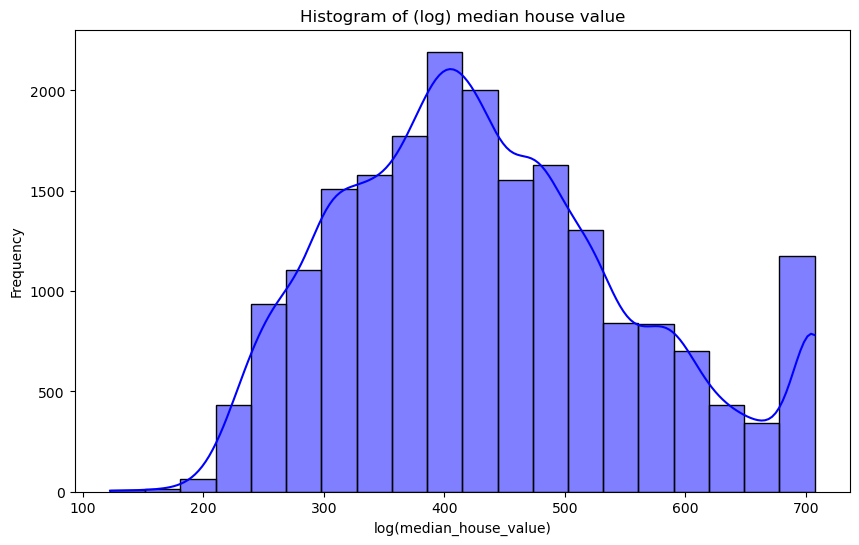

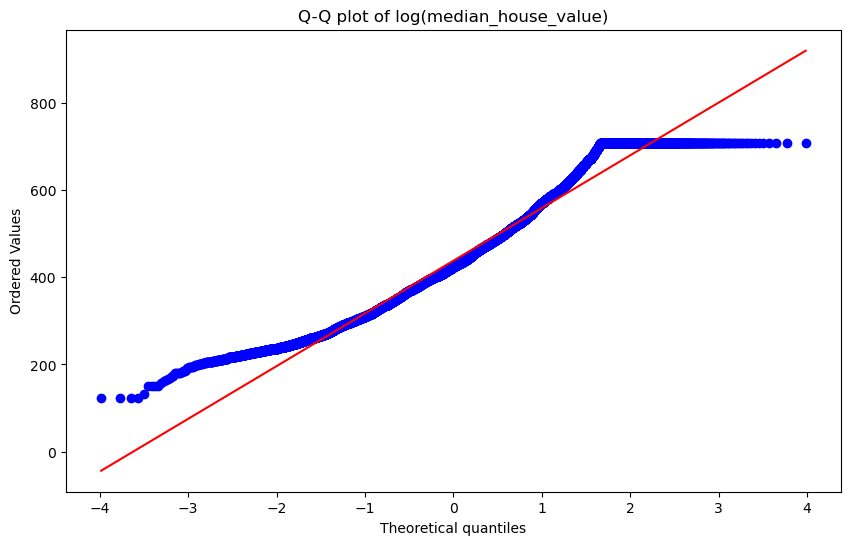

In [100]:
# TEST OF NORMALITY OF Y
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

# Extract the y variable
y = df['median_house_value_sqrt']

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Plot histogram of y variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='blue', bins=20)
plt.title('Histogram of (log) median house value')
plt.xlabel('log(median_house_value)')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q plot of log(median_house_value)')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [667]:
# Interpretation of Shapiro-Wilk test results:

Null Hypothesis (H0): The null hypothesis of the Shapiro-Wilk test is that the data are normally distributed.

Alternative Hypothesis (H1): The alternative hypothesis is that the data are not normally distributed.

Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is sufficient evidence that the data are not normally distributed.

# An outlier in the y column is observed too

# SOLUTION: Tree-Based Models (e.g. Decision trees, random forests, and gradient boosting machines) are flexible non-parametric models that do not 
            make explicit assumptions about the distribution of the response variable. They can handle non-linear relationships and are robust to 
            non-normality in the response.

For our assignement, we will fit as is (no data trimming, no transforming Y variable, etc.) and analyze residuals
    Residual Analysis: Analyzing the residuals of the linear regression model can provide insights into the presence and impact of outliers. 
    Residual plots, such as scatter plots of residuals against predicted values or fitted values, can help identify patterns and outliers that 
    may need further investigation.

SyntaxError: invalid syntax (2287512735.py, line 3)

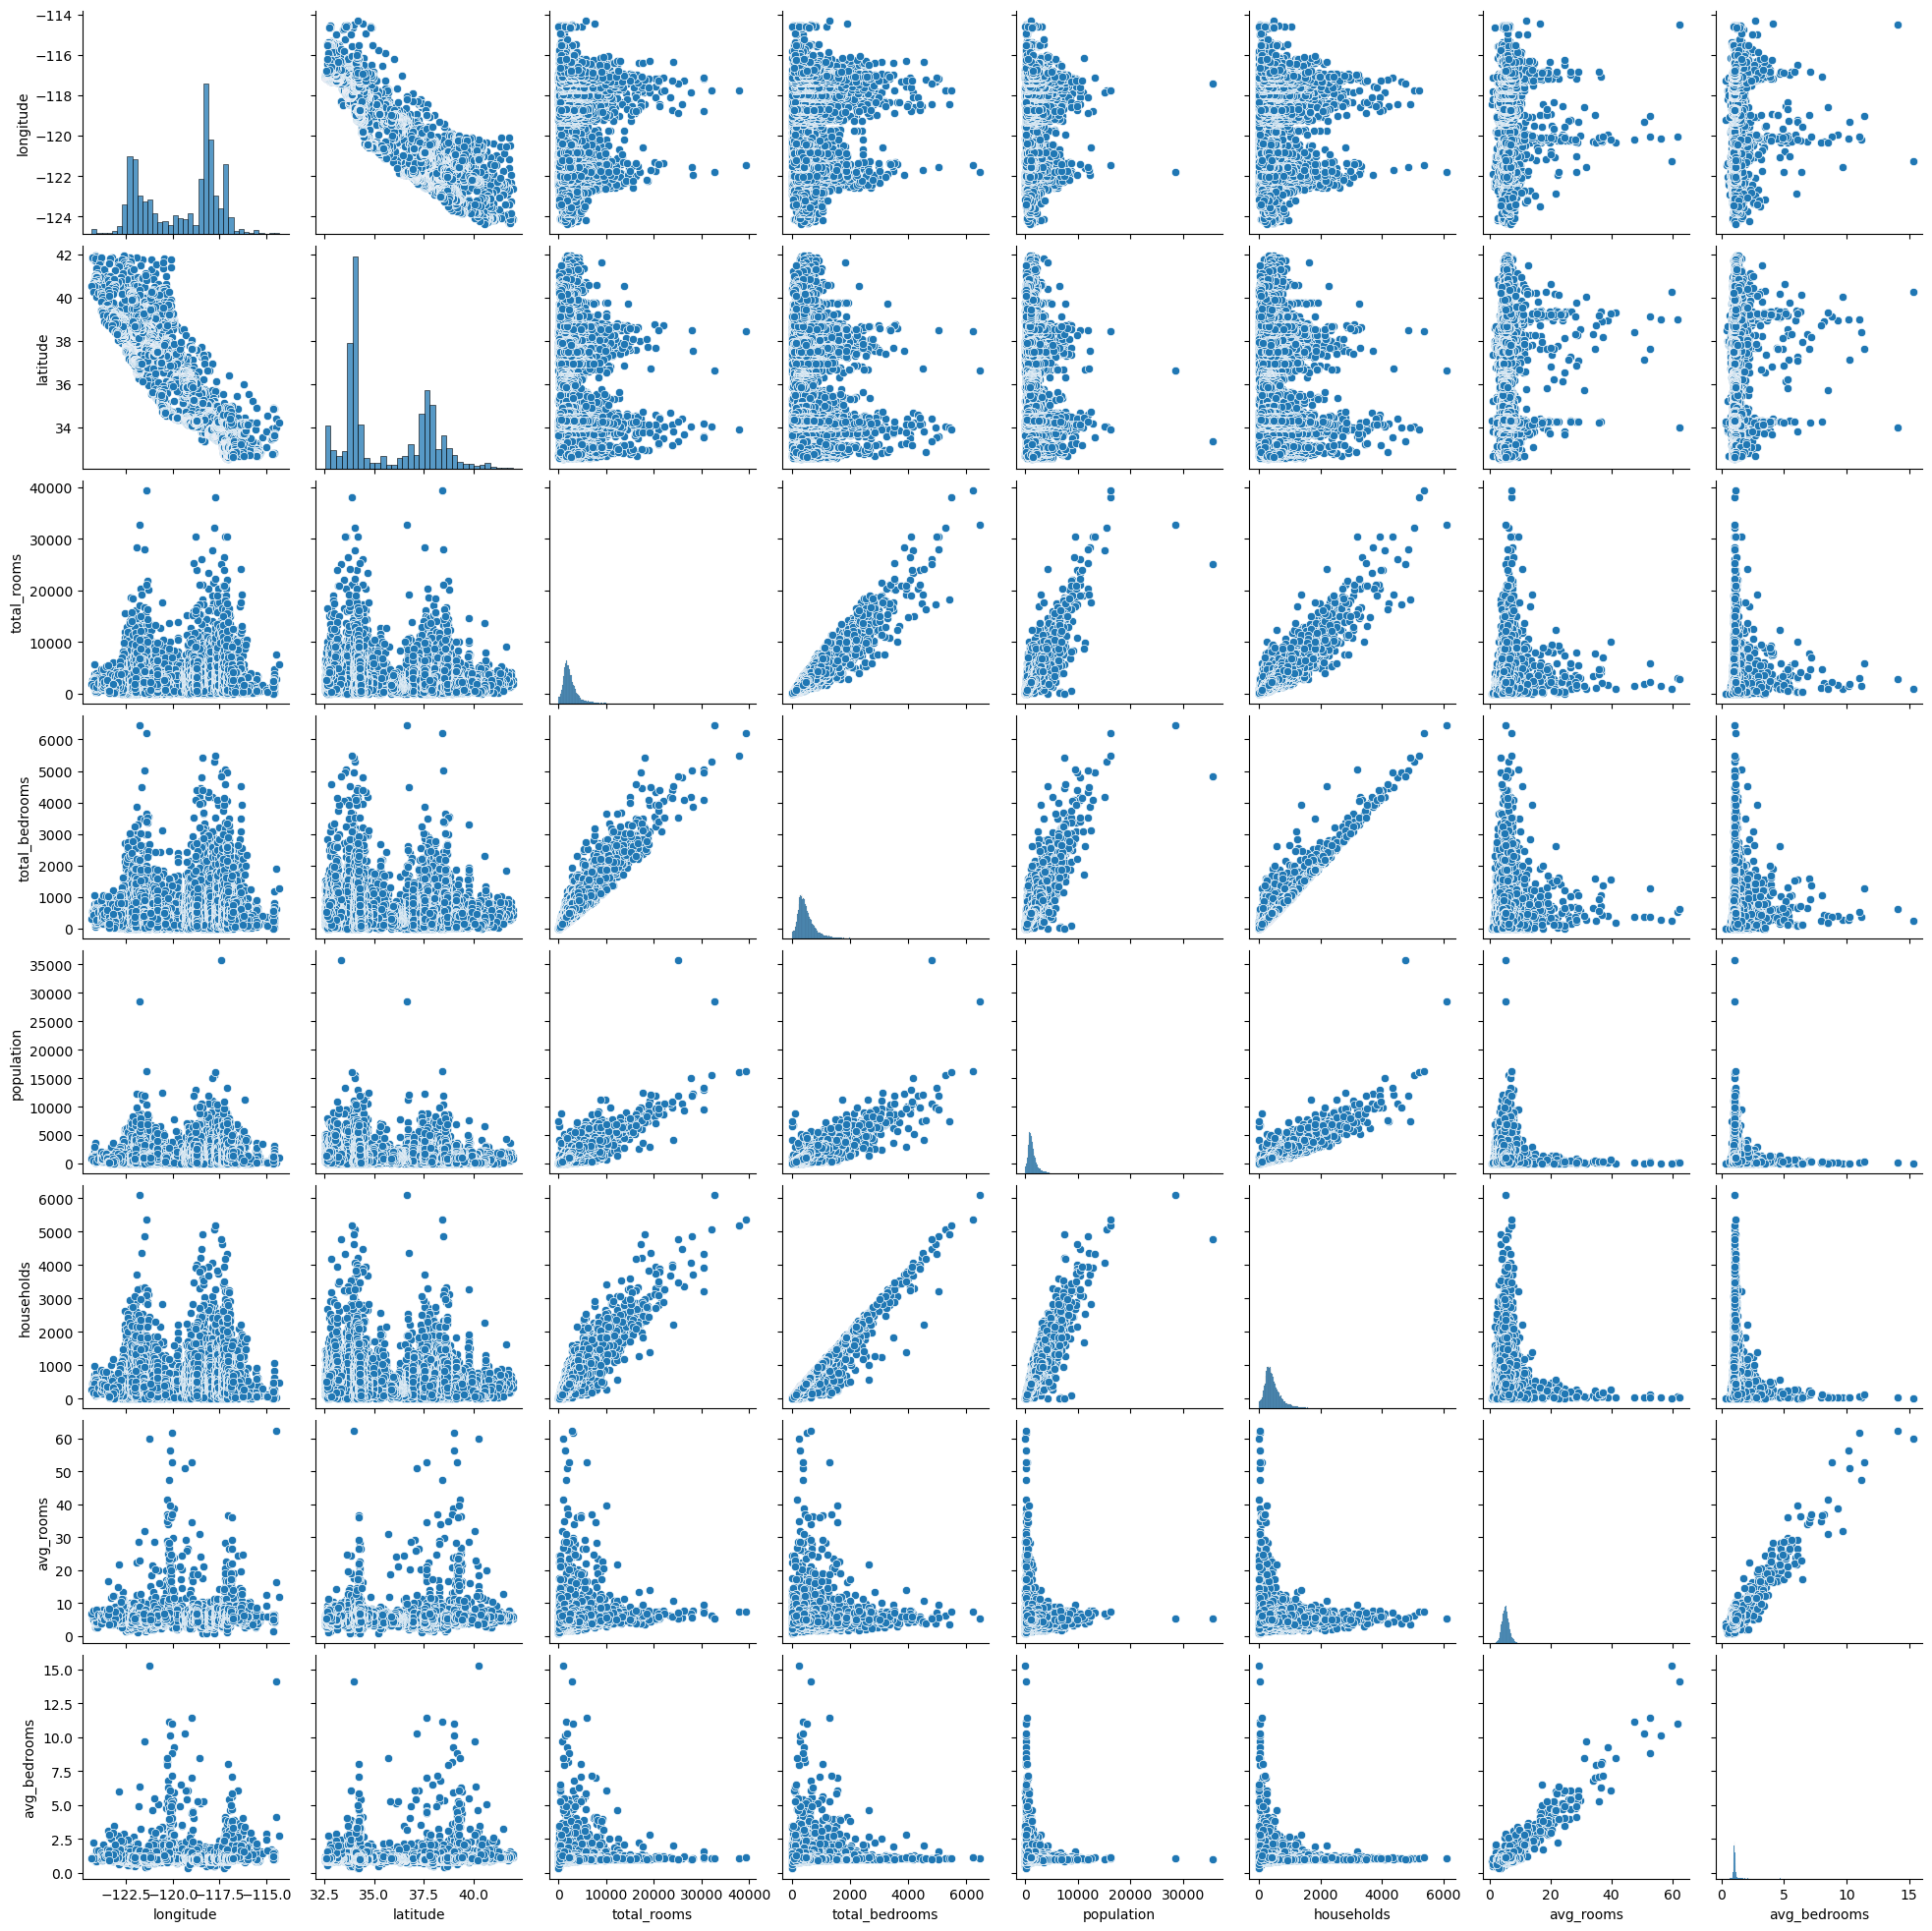

In [101]:

# Large pairwise correlations between predictors (> 0.8) consider dropping 1 variable
# Predictors that are a linear combination of 2 or more predictors
# Utilize formal diagnostics (VIF)

selected_columns = ['longitude', 'latitude', 'total_rooms', 'total_bedrooms', 'population', 'households','avg_rooms','avg_bedrooms']
subset_data = df[selected_columns]

sns.pairplot(subset_data)
plt.show()

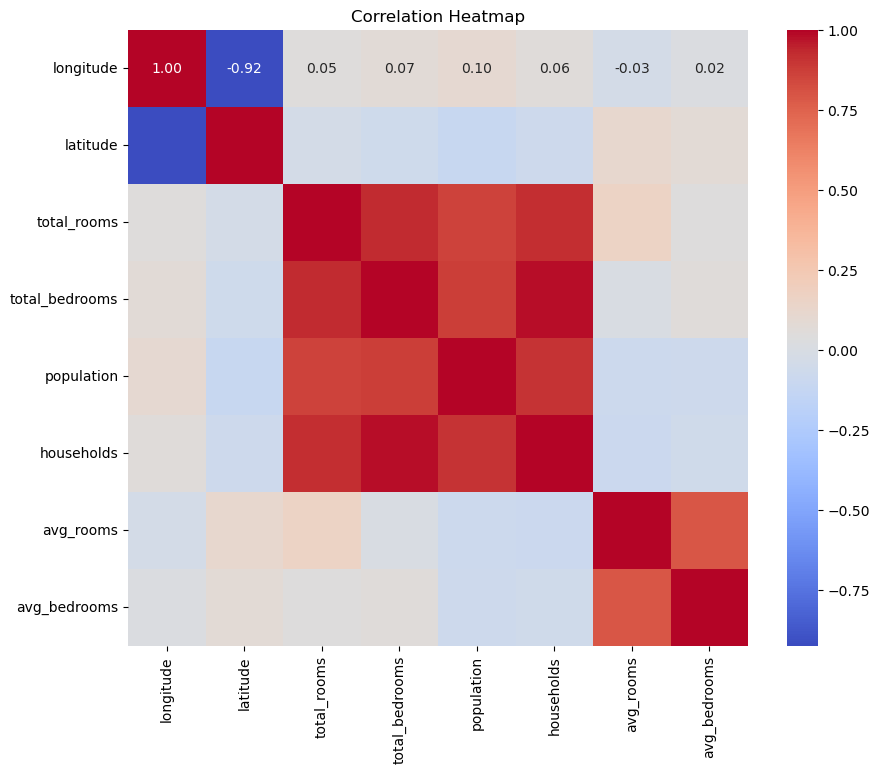

In [102]:
# Calculate the correlation matrix
correlation_matrix = subset_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [103]:
# Calculate the Pearson correlation matrix
correlation_matrix = subset_data.corr()

# Print the correlation matrix
print("Pearson Correlation Matrix:")
print(correlation_matrix)

Pearson Correlation Matrix:
                longitude  latitude  total_rooms  total_bedrooms  population  \
longitude        1.000000 -0.924710     0.045460        0.069597    0.100224   
latitude        -0.924710  1.000000    -0.036593       -0.066940   -0.108798   
total_rooms      0.045460 -0.036593     1.000000        0.930380    0.857304   
total_bedrooms   0.069597 -0.066940     0.930380        1.000000    0.877781   
population       0.100224 -0.108798     0.857304        0.877781    1.000000   
households       0.056474 -0.071584     0.919022        0.979773    0.907172   
avg_rooms       -0.030518  0.115911     0.159322        0.003915   -0.077012   
avg_bedrooms     0.018749  0.076686     0.039677        0.059769   -0.074339   

                households  avg_rooms  avg_bedrooms  
longitude         0.056474  -0.030518      0.018749  
latitude         -0.071584   0.115911      0.076686  
total_rooms       0.919022   0.159322      0.039677  
total_bedrooms    0.979773   0.0039

In [ ]:
Variables; households, population, total_bedrooms, and total_rooms have a strong correlation
longitude has a strong correlation with latitude. Since real estate is about location, the 2 will be kept. 
     geopy.geocoders to create ZipCode creates many missing values hence will be ignored.

In [104]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_orig', 'avg_rooms',
       'avg_bedrooms', 'median_house_value_sqrt', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'ocean_proximity'],
      dtype='object')

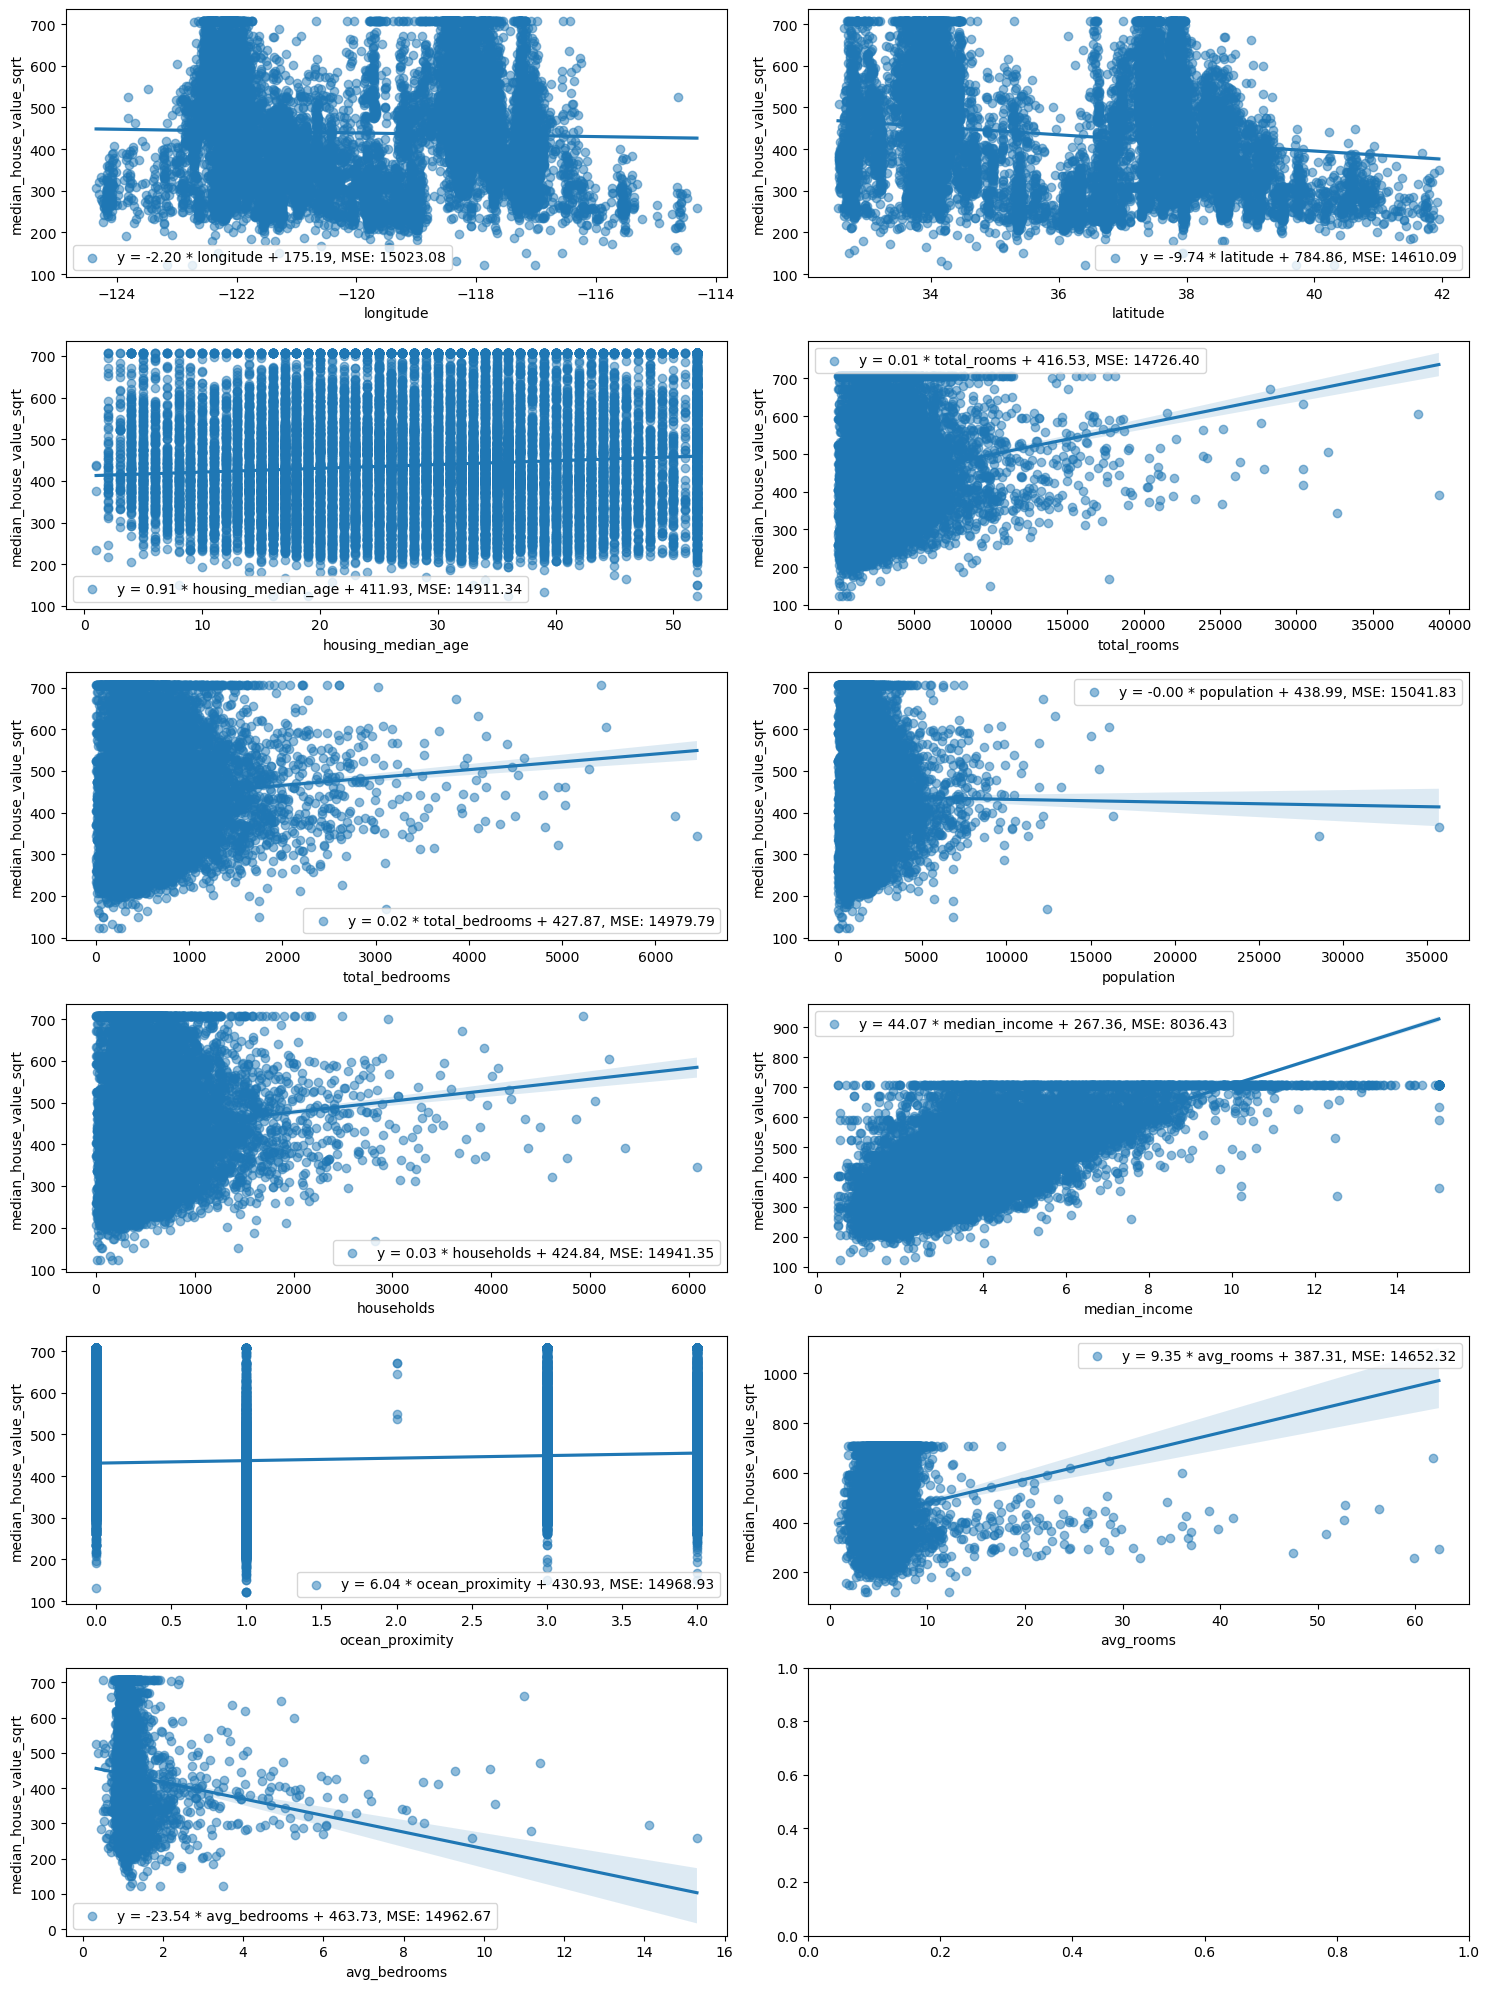

In [105]:
# Bivariate modeling & visualizations

# Define predictors (X) and target variable (y)
X = df[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','ocean_proximity','avg_rooms','avg_bedrooms']]
y = df['median_house_value_sqrt']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Create subplots for each predictor
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot each predictor against y with regression line
for i, predictor in enumerate(X.columns):
    sns.regplot(x=predictor, y=y, data=df, ax=axes[i], scatter_kws={'alpha':0.5})
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_imputed[:, i].reshape(-1, 1), y)
    
    # Make predictions
    predictions = model.predict(X_imputed[:, i].reshape(-1, 1))
    
    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Get slope (m) and intercept (b) of the regression line
    m = model.coef_[0]
    b = model.intercept_
    
    # Add equation to legend
    equation = f'y = {m:.2f} * {predictor} + {b:.2f}, MSE: {mse:.2f}'
    axes[i].legend([equation])

plt.tight_layout()
plt.show()


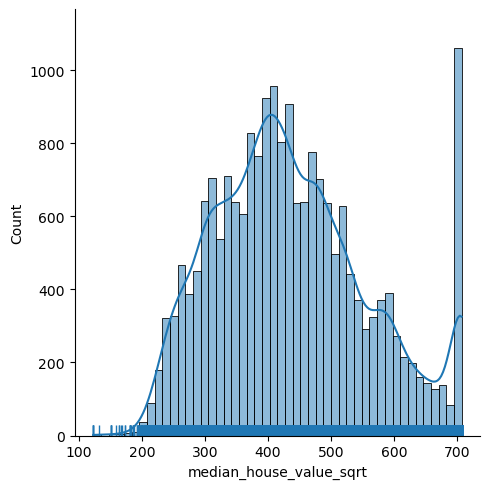

In [106]:
sns.displot(df["median_house_value_sqrt"], kde = True, rug = True)

In [ ]:
# No curvilinar relationship is observed hence no need for polynomials/higher order terms
# Inflated beta coefficients depict high multicollinearity
# solution: Use VIF to measure the inflation/multicollinearity 


In [107]:
column_names = df.columns
print(column_names)

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_orig', 'avg_rooms',
       'avg_bedrooms', 'median_house_value_sqrt', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'ocean_proximity'],
      dtype='object')


In [108]:
# TEST OF MULTICOLLINEARITY

X = df[['longitude','latitude','housing_median_age','total_rooms','total_bedrooms','population','households','median_income','ocean_proximity','avg_rooms','avg_bedrooms']]
y = df['median_house_value_sqrt']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16343, 11) (4086, 11) (16343,) (4086,)


In [109]:
# Impute ANY missing values in the dataframe using median

# Instantiate the imputer
imputer = SimpleImputer(strategy='median')  

#df = imputer.fit_transform(df)

# Fit the imputer on the training data and transform both training and test data
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


In [110]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

In [111]:
# cross validation
y_pred = lr_model.predict(X_test)

In [112]:
y_pred.shape

(4086,)

In [113]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [114]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
total_bedrooms,53.428216
households,48.712756
total_rooms,18.732750
avg_rooms,9.947119
longitude,9.944507
latitude,9.900132
avg_bedrooms,7.838130
population,6.458651
median_income,2.693370
housing_median_age,1.264501


In [680]:
# Since total_bedrooms, households and total_rooms all have a large VIF (> 10), they were excluded from the analysis. 
# Avg room & Avg bedroom kept in the model for re-fit since they are a linear combination of total bedroom/rooms & household

In [115]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_orig,avg_rooms,avg_bedrooms,median_house_value_sqrt,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,1.023810,672.755528,0.0,0.0,0.0,1.0,0.0,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.971880,598.748695,0.0,0.0,0.0,1.0,0.0,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,1.073446,593.380148,0.0,0.0,0.0,1.0,0.0,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,1.073059,584.208867,0.0,0.0,0.0,1.0,0.0,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,1.081081,584.978632,0.0,0.0,0.0,1.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20633,-121.53,39.19,27.0,2080.0,412.0,1082.0,382.0,2.5495,98300.0,INLAND,5.445026,1.078534,313.528308,0.0,1.0,0.0,0.0,0.0,1
20634,-121.56,39.27,28.0,2332.0,395.0,1041.0,344.0,3.7125,116800.0,INLAND,6.779070,1.148256,341.760150,0.0,1.0,0.0,0.0,0.0,1
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,5.045455,1.133333,279.463772,0.0,1.0,0.0,0.0,0.0,1
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,6.114035,1.315789,277.668868,0.0,1.0,0.0,0.0,0.0,1


In [131]:
# RE-FIT the model minus total_bedrooms, households and total_rooms
X = df[['longitude','latitude','housing_median_age','avg_rooms','avg_bedrooms','population','median_income','ocean_proximity']]
y = df['median_house_value_sqrt']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

# cross validation
y_pred = lr_model.predict(X_test)


(16343, 8) (4086, 8) (16343,) (4086,)


In [132]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [133]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
longitude,9.835079
latitude,9.815106
avg_rooms,6.595801
avg_bedrooms,5.170029
median_income,2.632318
housing_median_age,1.242919
ocean_proximity,1.144167
population,1.134409


In [134]:
# Compute residuals
residuals = y_test - y_pred
residuals.shape

(4086,)

In [135]:
residuals

12886     52.068754
3197     -73.015018
15202    -35.509529
15311    323.335315
8306     222.951489
            ...    
2007     -72.778634
14979    -87.417709
17920    -70.375857
9871     -81.958040
2452     -49.664362
Name: median_house_value_sqrt, Length: 4086, dtype: float64

In [136]:
y_pred

array([318.7411699 , 417.6887769 , 533.90696035, ..., 515.79700563,
       493.17574424, 314.4284082 ])

In [137]:
r = permutation_importance(lr_model, X_test, y_test, random_state=123)
r.importances_mean

array([ 1.64842058e+00,  1.71376442e+00,  1.27033730e-02,  6.74892564e-02,
        9.66021678e-02,  1.09993989e-05,  9.24587192e-01, -3.53684026e-04])

In [138]:
r.importances

array([[ 1.71569971e+00,  1.64532975e+00,  1.62384621e+00,
         1.65837563e+00,  1.59885158e+00],
       [ 1.70408343e+00,  1.74523747e+00,  1.69659437e+00,
         1.69709808e+00,  1.72580876e+00],
       [ 1.38229816e-02,  1.04502999e-02,  1.31706171e-02,
         1.22783415e-02,  1.37946249e-02],
       [ 6.65775403e-02,  6.94839389e-02,  6.93938681e-02,
         6.73130624e-02,  6.46778724e-02],
       [ 1.00463877e-01,  9.53528944e-02,  9.08073814e-02,
         9.65077847e-02,  9.98789019e-02],
       [-4.71368607e-05,  3.37248044e-05,  7.16626766e-05,
         1.13803770e-05, -1.46340026e-05],
       [ 9.31107768e-01,  8.84489824e-01,  9.49974672e-01,
         9.19413993e-01,  9.37949703e-01],
       [-5.99331197e-04, -1.81090895e-04, -3.47663038e-04,
        -4.39966065e-04, -2.00368936e-04]])

In [139]:
importance_tuples = list(zip(X.columns, r.importances_mean))
sorted_importance_tuples = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance_tuples:
    print(feature, importance)

latitude 1.713764423368335
longitude 1.6484205764347633
median_income 0.9245871922460946
avg_bedrooms 0.09660216780863809
avg_rooms 0.06748925641062051
housing_median_age 0.012703372999400076
population 1.099939892701407e-05
ocean_proximity -0.00035368402611219986


In [140]:
# for i in zip(X.columns, r.importances_mean):
#    print(i)

In [141]:
print(X_test.shape, y_test.shape,y_pred.shape, residuals.shape)

(4086, 8) (4086,) (4086,) (4086,)


In [147]:
# Convert y_pred to a DataFrame
#y_pred_df = pd.DataFrame(y_pred, columns=["y_pred"])

residuals_df = pd.DataFrame(residuals, columns=["median_house_value_sqrt"])
residuals_df.rename(columns={'median_house_value_sqrt': 'Residuals'}, inplace=True)

# Concatenate y_pred and residuals DataFrames with the test DataFrame
#df_with_predictions = pd.concat([X_test, y_test, y_pred_df, residuals_df], axis=1)

# Now you have df_with_predictions DataFrame containing original data along with y_pred and residuals
#df_with_predictions


In [148]:
residuals_df

,Residuals
12886,52.068754
3197,-73.015018
15202,-35.509529
15311,323.335315
8306,222.951489
...,...
2007,-72.778634
14979,-87.417709
17920,-70.375857
9871,-81.958040


Shapiro-Wilk Test - Test Statistic: 0.9590365886688232, p-value: 1.7759730116735998e-32


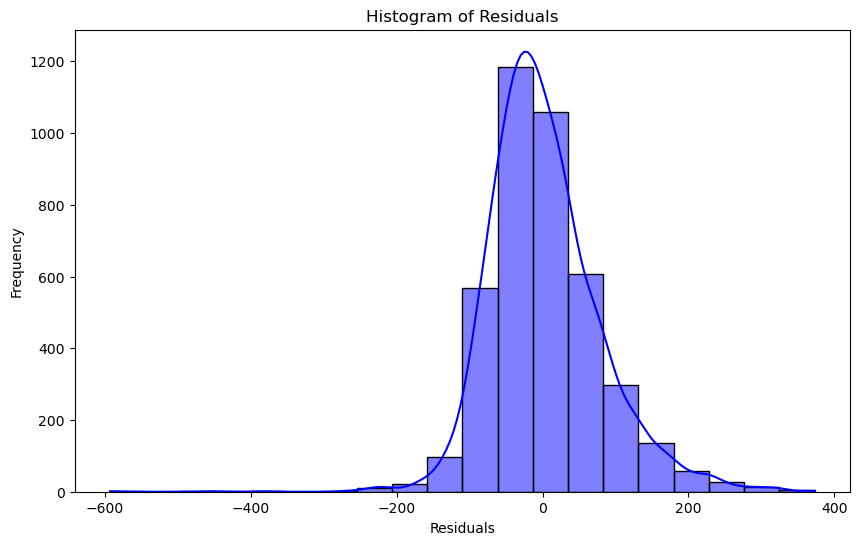

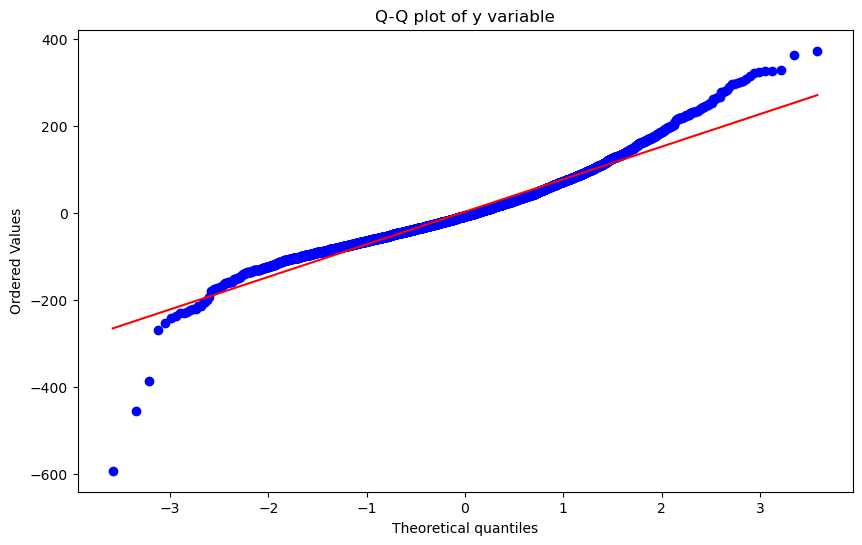

In [149]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

# Extract the y variable
y = residuals_df['Residuals']

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Plot histogram of y variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='blue', bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q plot of y variable')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')
plt.show()

In [692]:
# Based on the extremely small p-value of the shapiro Wilk test, we reject the null hypothesis and conclude that the data does not come from a 
# normally distributed population. Therefore, the data likely deviates from a normal distribution.

In [150]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity_orig', 'avg_rooms',
       'avg_bedrooms', 'median_house_value_sqrt', 'ocean_proximity_<1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN',
       'ocean_proximity'],
      dtype='object')

Breusch-Pagan Test Statistic: 1072.3801452662722
Breusch-Pagan p-value: 2.75015242459462e-227


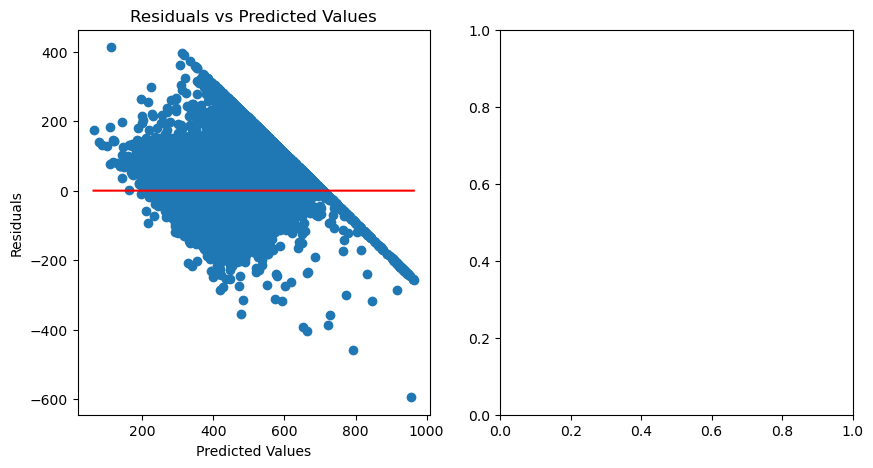

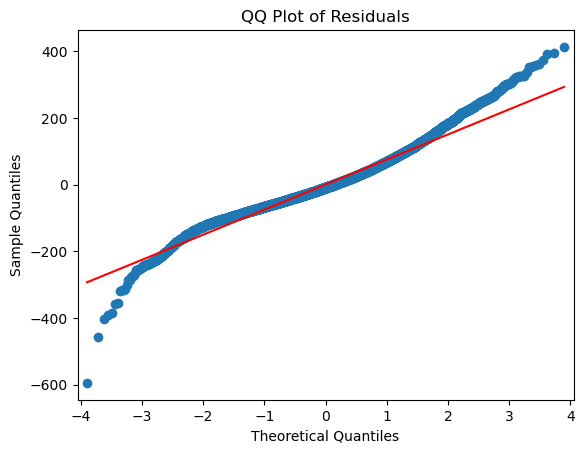

Shapiro-Wilk Test Statistic: 0.9677219390869141
Shapiro-Wilk p-value: 0.0


In [151]:
# Preliminary model 

import numpy as np
import statsmodels.api as sm
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import scipy.stats as stats

# Step 1: Fit the multiple linear regression model
X = df[['longitude', 'latitude', 'housing_median_age', 'avg_rooms', 'avg_bedrooms', 'median_income', 'ocean_proximity']]
y = df['median_house_value_sqrt']
X = sm.add_constant(X)  # Add a constant term to the predictor variables
model = sm.OLS(y, X).fit()

# Step 2: Compute the residuals
residuals = model.resid

# Step 3: Compute the Breusch-Pagan test statistic and p-value
bp_test_statistic, bp_p_value, _, _ = sms.het_breuschpagan(residuals, X)
print("Breusch-Pagan Test Statistic:", bp_test_statistic)
print("Breusch-Pagan p-value:", bp_p_value)

# Step 4: Plot the residual vs predicted values with a fitted regression line of best fit
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
# Add a regression line
plt.plot(np.unique(model.fittedvalues), np.poly1d(np.polyfit(model.fittedvalues, residuals, 1))(np.unique(model.fittedvalues)), color='red')

# Step 5: Plot the QQ plot of the residual
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s')
plt.title("QQ Plot of Residuals")
plt.show()

# Step 6: Perform the Shapiro-Wilk test on the residuals
shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals)
print("Shapiro-Wilk Test Statistic:", shapiro_test_statistic)
print("Shapiro-Wilk p-value:", shapiro_p_value)


In [154]:
# BEST TRANSFORMATION

X = df[['longitude', 'latitude', 'housing_median_age', 'avg_rooms', 'avg_bedrooms', 'median_income', 'ocean_proximity']]
y = df['median_house_value']

# Define different transformations
transformations = ['log', 'sqrt', 'boxcox', 'reciprocal']

best_score = -np.inf
best_transformation = None
best_model = None

for transformation in transformations:
    # Apply transformation to the target variable
    if transformation == 'log':
        y_transformed = np.log(y)
    elif transformation == 'sqrt':
        y_transformed = np.sqrt(y)
    elif transformation == 'boxcox':
        y_transformed, _ = stats.boxcox(y)
    elif transformation == 'reciprocal':
        y_transformed = 1 / y
#    elif transformation == 'exp':
 #       y_transformed = np.exp(y)
    
    # Fit linear regression model
    model = LinearRegression().fit(X, y_transformed)
    
    # Evaluate model performance
    y_pred_transformed = model.predict(X)
    score = r2_score(y_transformed, y_pred_transformed)
    
    # Update best transformation if necessary
    if score > best_score:
        best_score = score
        best_transformation = transformation
        best_model = model

print("Best transformation:", best_transformation)
print("Best R-squared score:", best_score)


Best transformation: sqrt
Best R-squared score: 0.6239652434788513


In [156]:

# BEST MODEL SELECTION by backward elimination

X = df[['longitude','latitude','housing_median_age','avg_rooms','avg_bedrooms','population','median_income','ocean_proximity_<1H OCEAN','ocean_proximity_INLAND','ocean_proximity_ISLAND','ocean_proximity_NEAR BAY','ocean_proximity_NEAR OCEAN']]
y = df['median_house_value_sqrt']

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Perform backward elimination on the training set
def backward_elimination(X, y, significance_level=0.05):
    model = LinearRegression()
    num_features = X.shape[1]
    for i in range(num_features):
        model.fit(X, y)
        p_values = sm.OLS(y, X).fit().pvalues[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            max_p_value_idx = p_values.idxmax()
            X = X.drop(max_p_value_idx, axis=1)
        else:
            break
    return model, X

# Fit the initial model and perform backward elimination
model, X_train_final = backward_elimination(X_train, y_train)

#print(X_train_final)


# Find the missing/dropped columns during backward elimination process
missing_cols = set(X_train.columns) - set(X_val.columns)

# Drop the columns from the training set too
X_train_final = X_train.drop(columns=missing_cols)

# Fit the model using the modified training set
model.fit(X_train_final, y_train)

# Step 3: Validate the model on the validation set
# Predict on the validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)

# Step 4: Evaluate the final model on the test set
# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Print validation and test MSE
print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)


Validation MSE: 5695.827946507801
Test MSE: 5313.416161872877


In [696]:

# MODEL EQUATION and PARAMETER ESTIMATES

# Fit the model using the modified training set
model.fit(X_train_final, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_final_with_intercept = sm.add_constant(X_train_final)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_final_with_intercept).fit()
p_values = model_sm.pvalues

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj


# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("Parameter Estimates:")
for feature, coef, p_value in zip(X_train_final.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train_final.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")

Parameter Estimates:
longitude: Coef = -26972.1401, p-value = 0.0000
latitude: Coef = -25167.4204, p-value = 0.0000
housing_median_age: Coef = 872.9293, p-value = 0.0000
avg_rooms: Coef = -10264.3397, p-value = 0.0000
avg_bedrooms: Coef = 64652.0898, p-value = 0.0000
population: Coef = -0.9238, p-value = 0.0000
median_income: Coef = 42800.6057, p-value = 0.1256
ocean_proximity_<1H OCEAN: Coef = -33463.5903, p-value = 0.0000
ocean_proximity_INLAND: Coef = -69487.7150, p-value = 0.0000
ocean_proximity_ISLAND: Coef = 160727.4243, p-value = 0.0000
ocean_proximity_NEAR BAY: Coef = -31987.1884, p-value = 0.0000
ocean_proximity_NEAR OCEAN: Coef = -25788.9306, p-value = 0.0000
Intercept: -2282314.3368

R-squared: 0.616316201492874
Adjusted R-squared: 0.6159715847064302

Equation: y = -2282314.3368 + (-26972.1401 * longitude) + (-25167.4204 * latitude) + (872.9293 * housing_median_age) + (-10264.3397 * avg_rooms) + (64652.0898 * avg_bedrooms) + (-0.9238 * population) + (42800.6057 * median_inco